In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import umap

from tqdm import tqdm
import os

from src.models import ContextSpaceNet, OldSpaceNet, RecurrentSpaceNet, Decoder, End2EndSpaceNet
from src.utils import ratemap_collage, SimpleDatasetMaker

plt.rcdefaults()
plt.style.use("figures/project_style.mplstyle")
%matplotlib inline

In [22]:
figure_path = '/Users/frederikrogge/Documents/Projekte/PhD/Projects/BSR/figures-reviewers'

# Circle, big square (or rectangle)

In [23]:
path = "/Users/frederikrogge/Data/bsr/reviewers"

loss: 0.000361: 100%|██████████| 50000/50000 [00:55<00:00, 895.32it/s] 


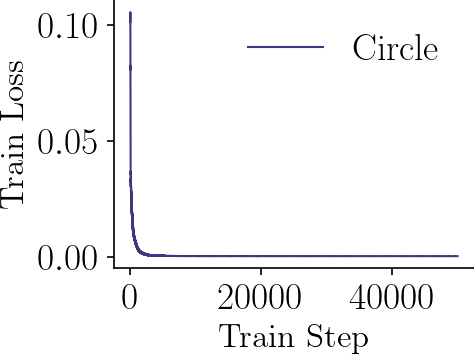

In [24]:
# ----------------------- Params -----------------------
train_steps = 50000    # no. of training steps
bs = 64                # batch size
n_in = 2               # 2 position inputs
scale = 0.25           # scale of the gaussian
lam = 0.1              # regularization strength
lr = 1e-4              # learning rate
beta = 0.5             # rescaling parameter
env = 'circle'         # square, circle
width = 2              # width of the square
height = 2             # height of the square

# Define model
model = OldSpaceNet(n_in, 100, scale=scale, lam=lam)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train model
loss_history = []
progress = tqdm(range(train_steps))
for i in progress:

    # Sample random batch 
    if env == 'square':
        
        if width == height:
            r = torch.tensor(np.random.uniform(-width/2, width/2, (bs, 2)), dtype=torch.float32)
        else:
            x = np.random.uniform(-width/ 2, width / 2, bs)
            y = np.random.uniform(-height / 2, height / 2, bs)
            r = torch.tensor(np.stack([x, y], axis=-1), dtype=torch.float32)
            
    elif env == 'circle':
        r = torch.tensor(np.sqrt(np.random.uniform(0, 1, bs)), dtype=torch.float32)
        theta = torch.tensor(np.random.uniform(0, 2 * np.pi, bs), dtype=torch.float32)
        x = r * torch.cos(theta)
        y = r * torch.sin(theta)
        r = torch.stack((x, y), dim=1)
    else:
        raise ValueError("Environment not recognized")
    
    # Perform train step
    loss = model.train_step(x=r, y=r, optimizer=optimizer)

    # Save loss
    loss_history.append(loss)

    # Update progress bar
    if i % 10 == 0:
        progress.set_description(f"loss: {loss:>7f}")
        
# Plot loss
plt.plot(loss_history, label="Circle")

plt.xlabel("Train Step")
plt.ylabel("Train Loss")
plt.legend()
plt.show()


In [25]:
n_grid = 512
x = np.linspace(-width/2, width/2, n_grid * width)
y = np.linspace(-height/2, height/2, n_grid * height)
xx, yy = np.meshgrid(x,y)

if env == 'circle':
    # Flatten the meshgrid to work with the points as vectors
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    
    # Calculate the distance from the origin
    distance = np.sqrt(xx_flat**2 + yy_flat**2)
    
    # Filter the points to include only those within the circle of radius 1
    inside_circle = distance <= 1
    xx = xx_flat[inside_circle]
    yy = yy_flat[inside_circle]   

u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)
p = model.spatial_representation(u).detach().numpy()

if env == 'circle':
    # Create a grid of nans
    total_p = np.full((xx_flat.shape[0], p.shape[-1]), np.nan)
    total_p[inside_circle] = p  
    p = total_p
    


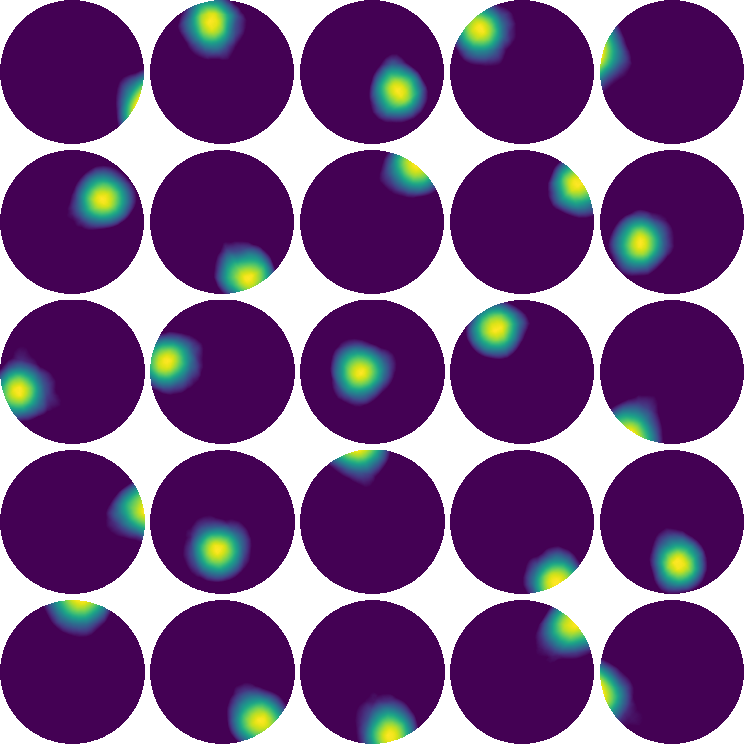

In [26]:
# Find cells with nonzero values
mask = np.nanmean(p, axis=0) > 0
ratemaps = p.T[mask].reshape(-1, x.shape[0], y.shape[0])

# Plot first 25 ratemaps (active units)
fig, ax = ratemap_collage(ratemaps[:25], cmap="viridis", figsize=(5, 5))     # jet, viridis
plt.show()

fig.savefig(os.path.join(figure_path, "circle_ratemaps.png"), bbox_inches='tight', transparent=True)

# PCA

In [27]:
path = "/Users/frederikrogge/Data/bsr/rnn-new"

In [28]:
# Load models
models = {
    "100 units context initial state": [torch.load(f"{path}/100 units context initial state_{i}.pt") for i in range(10)],
    "100 units": [torch.load(f"{path}/100 units_{i}.pt") for i in range(10)]
}

# Load loss histories
loss_histories = {name: [np.load(f"{path}/{name}_{i}_loss_history.npy") for i in range(10)] for name in models.keys()}

model_name_map = {
    'w/o context': 'w/o context',
    'with context': 'with context',
}

In [29]:
cmap = plt.get_cmap("viridis")
contexts = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
contexts = [-5, -3, 0, 3, 5]
contexts = [-2, -1, 0, 1, 2]
# contexts = [-1, 0, 1]
context_colors = [cmap(i) for i in np.linspace(0, 1, len(contexts))]

In [30]:
# Load model
model_name = "100 units context initial state"
model = models[model_name][0]

# visualize representations
n_plot = 50000               # For umap trajectories choose 5000, for maps something like 50000  
timesteps = 10
bins = 32
context_in_initial = True

genny = SimpleDatasetMaker()

representations, colors, ratemaps = [], [], []
for i, context in enumerate(contexts):
    
    # Generate dataset
    r, v = genny.generate_dataset(n_plot, timesteps)
    
    # BSR
    c = torch.ones(n_plot, timesteps-1, 1) * context
    input = torch.cat((v, c), dim = -1)
    
    # Get initial input
    if context_in_initial:
        initial_input = torch.cat((r[:, 0], c[:, 0]), dim=-1)
    else:
        initial_input = r[:, 0]
    
    # Get spatial representation
    p,_ = model.spatial_representation(input, model.p0(initial_input)[None])
    p = p.detach().numpy()
    ps = p.reshape(-1, p.shape[-1])
    
    rs = r[:, 1:].detach().numpy().reshape(-1, 2)
    ratemap, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1], ps.T, bins=bins)
    
    representations.append(ps)
    colors.extend([context_colors[i]] * ps.shape[0])
    ratemaps.append(ratemap.reshape(100, -1).T)

# Concatenate
representations = np.concatenate(representations, axis=0)
ratemaps = np.concatenate(ratemaps, axis=0)

In [31]:
ratemap_colors, ratemap_labels = [], []
for i in range(len(contexts)):
    ratemap_colors.extend([context_colors[i]] * bins**2)
    ratemap_labels.extend([contexts[i]] * bins**2)

In [32]:
ratemaps[np.isnan(ratemaps)] = 0

reducer = umap.UMAP(n_components=2)
umap_trajectories_maps = reducer.fit_transform(ratemaps)

Text(0, 0.5, 'UMAP Dim 2')

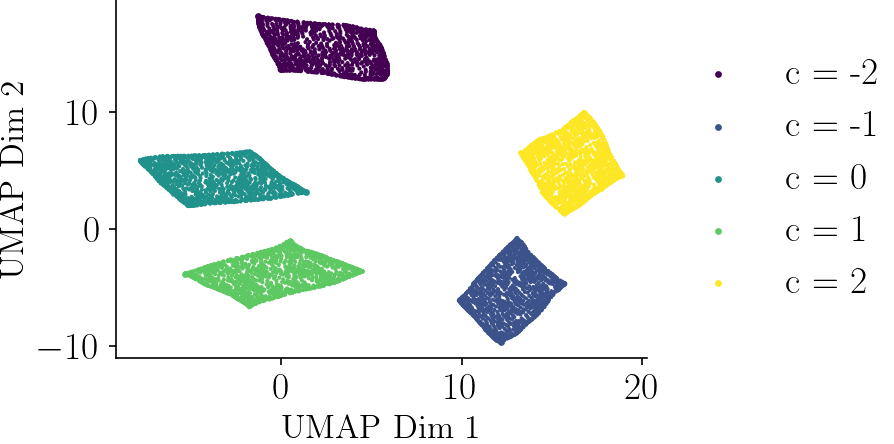

In [33]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(umap_trajectories_maps[:, 0], umap_trajectories_maps[:, 1], color=ratemap_colors)
for i in range(len(contexts)):
    ax.scatter(umap_trajectories_maps[i * bins**2, 0], umap_trajectories_maps[i * bins**2, 1], color=ratemap_colors[i * bins**2], label=f"c = {contexts[i]}", s=5)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel('UMAP Dim 1')
ax.set_ylabel('UMAP Dim 2')

# fig.savefig(os.path.join(figure_path, 'rnn_context_umap_maps.svg'), transparent=True)

c = -2: 7 components explain 90% of the variance
c = -1: 9 components explain 90% of the variance
c = 0: 8 components explain 90% of the variance
c = 1: 9 components explain 90% of the variance
c = 2: 6 components explain 90% of the variance
All: 0 components explain 90% of the variance


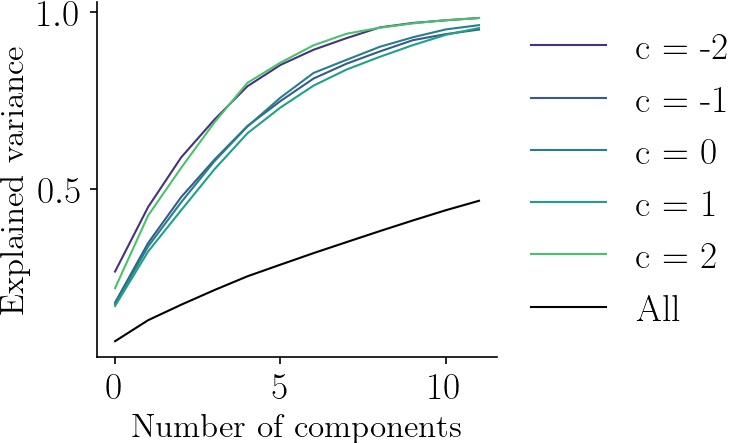

In [34]:
fig, ax = plt.subplots(figsize=(5, 3))
for i in range(len(contexts)):
    
    pca = PCA(n_components=12)
    pca.fit(ratemaps[i * bins**2: (i+1) * bins**2, :])
    ax.plot(np.cumsum(pca.explained_variance_ratio_), label=f"c = {contexts[i]}")
    
    # Find number of components that explain 90% of the variance
    n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.9)
    print(f"c = {contexts[i]}: {n_components} components explain 90% of the variance")
    
pca = PCA(n_components=12)
pca.fit(ratemaps)
ax.plot(np.cumsum(pca.explained_variance_ratio_), label="All", color='black')

n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.9)
print(f"All: {n_components} components explain 90% of the variance")

ax.set_xlabel("Number of components")
ax.set_ylabel("Explained variance")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    
fig.savefig(os.path.join(figure_path, 'rnn_context_pca_maps.png'), transparent=True)

# Long trajectory

In [4]:
path = "/Users/frederikrogge/Data/bsr/reviewers"

In [7]:
# ----------------------- Params -----------------------
train_steps = 100      # no. of training steps
timesteps = 2500          # Length of trajectories
bs = 64                 # Batch size
n_in = 2                # Cartesian coordinates + 1 context
lr = 1e-4               # Learning rate
beta = 0.5              # Rescaling parameter
scale = 0.25            # Scale of the spatial representation
n_out = 100             # Number of units in the spatial representation

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Analyze for different model parameters
model = RecurrentSpaceNet(n_in=n_in, n_out=n_out, corr_across_space=False, scale=scale, beta=beta, device=device)
# model = RecurrentSpaceNet(n_in=n_in, n_out=n_out, corr_across_space=True, scale=scale, beta=beta, device=device)
        
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
genny = SimpleDatasetMaker(rayleigh_scale=0.1)    # use simple dataset

loss_history = []
progress = tqdm(range(train_steps))
for k in progress:  
    
    # Create data
    r, v = genny.generate_dataset(bs, timesteps, device=device)

    # Train step
    # loss = model.train_step(x=(v, r[:, 0]), y=r[:, 1:], optimizer=optimizer)
    loss = model.train_step(x=v, y=r[:, 1:], optimizer=optimizer)

    loss_history.append(loss)
    
    if k % 10 == 0:
        progress.set_description(f"loss: {loss:>7f}")
        

loss: 0.073715: 100%|██████████| 100/100 [13:49<00:00,  8.29s/it]


In [9]:
# Save model
torch.save(model, f"{path}/rnn_very_long_trajectory.pt")

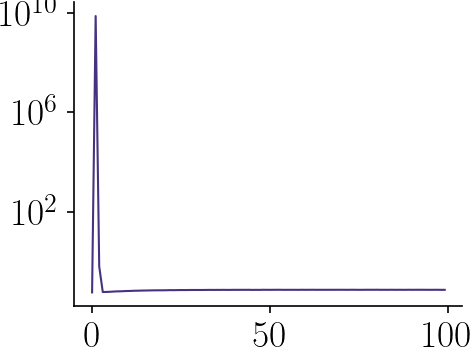

In [10]:
# Plot loss
plt.semilogy(loss_history)

In [18]:
timesteps = 2500
n_samples = 1
n_bins = 16

genny = SimpleDatasetMaker()
r, v = genny.generate_dataset(n_samples, timesteps)

initial_state = model.initial_state(v.shape[0])
# or 
# initial_state = model.p0(r[:, 0])[None]

p, _ = model.spatial_representation(v, initial_state)
p = p.detach().numpy()


In [19]:
start_idx = 0

ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
# ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1], ps.T, bins=n_bins)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[start_idx:,0], rs[start_idx:,1], ps[start_idx:].T, bins=n_bins)

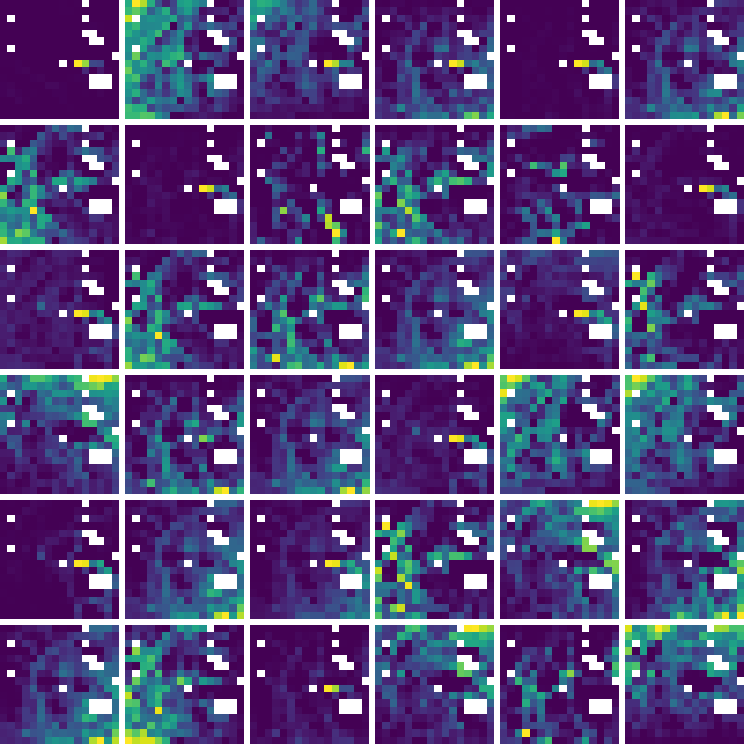

In [20]:
# Optionally, select a subset of ratemaps
plt_ratemaps = ratemaps
# plt_ratemaps = ratemaps[np.max(ratemaps, axis=(1, 2)) > 0.2]

# Plot first 25 ratemaps (active units)
fig, ax = ratemap_collage(plt_ratemaps[:36], cols=6, cmap="viridis")     
plt.show()

# fig.savefig(os.path.join(figure_path, f'rnn_ratemaps_{model_name}_high_peak.svg'), transparent=True)